In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import nasdaqdatalink
import os
from dotenv import load_dotenv
from statsmodels.api import OLS, add_constant
load_dotenv()
API_KEY= os.getenv('API_KEY')
nasdaqdatalink.ApiConfig.api_key = API_KEY

# Load in Asset Data

In [2]:

# Define the asset universe
tickers = {
    # US Equities
    'SPY': 'QUOTEMEDIA/PRICES',  # S&P 500 ETF
    'QQQ': 'QUOTEMEDIA/PRICES',  # Nasdaq 100 ETF
    'IWM': 'QUOTEMEDIA/PRICES',  # Russell 2000 ETF (Small Cap)
    # International Equities
    'EFA': 'QUOTEMEDIA/PRICES',  # MSCI EAFE ETF (Developed Markets ex-US/Canada)
    'EEM': 'QUOTEMEDIA/PRICES',  # MSCI Emerging Markets ETF
    # Fixed Income
    'AGG': 'QUOTEMEDIA/PRICES',  # US Aggregate Bond ETF
    'TLT': 'QUOTEMEDIA/PRICES',  # US 20+ Year Treasury Bond ETF
    # Commodities
    'GLD': 'QUOTEMEDIA/PRICES',  # Gold ETF
    'USO': 'QUOTEMEDIA/PRICES',  # Oil ETF
    # Real Estate
    'VNQ': 'QUOTEMEDIA/PRICES',   # US Real Estate ETF
    # Adding a couple more for diversity
    'GSG': 'QUOTEMEDIA/PRICES', # Broad Commodities ETF
    'HYG': 'QUOTEMEDIA/PRICES'  # High Yield Corporate Bond ETF
}

start_date = '2010-01-01'


In [3]:
# Fetch data for each ticker
all_data = {}
for ticker, table in tickers.items():
    try:
        # Fetch data from the specified start_date
        data = nasdaqdatalink.get_table(
            table, 
            ticker=ticker, 
            qopts={'columns': ['date', 'adj_close']},
            date={'gte': start_date},
            paginate=True
        )
        if not data.empty:
            data = data.set_index('date')
            all_data[ticker] = data['adj_close']
        else:
            print(f"No data found for {ticker}")
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

# Combine into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    price_df = price_df.sort_index() # Ensure dates are in ascending order
    print("\nSuccessfully fetched and combined data for all available tickers.")
    print(f"Price data from {price_df.index.min()} to {price_df.index.max()}")
else:
    print("No data was fetched. Please check ticker symbols and API key.")


Successfully fetched and combined data for all available tickers.
Price data from 2010-01-04 00:00:00 to 2025-05-14 00:00:00


In [4]:
# Resample to monthly frequency (end of month) and calculate returns
if 'price_df' in locals() and not price_df.empty:
    # Forward fill to handle missing values before resampling, then backfill
    price_df_filled = price_df.ffill().bfill()
    
    # Resample to monthly frequency, taking the last available price in the month
    monthly_prices = price_df_filled.resample('ME').last()
    
    # Calculate monthly returns
    monthly_returns = monthly_prices.pct_change()
    
    # Drop the first row of NaNs resulting from pct_change()
    monthly_returns = monthly_returns.dropna(how='all', axis=0)

else:
    print("price_df is not available or empty. Cannot calculate monthly returns.")

In [5]:
# Standardize the monthly returns by their volatility
if 'monthly_returns' in locals() and not monthly_returns.empty:
    # Calculate the standard deviation for each asset's monthly returns
    returns_std = monthly_returns.std()
    
    # Standardize the returns
    # Avoid dividing by zero if any asset has zero standard deviation (e.g., if all returns are the same or NaN)
    standardized_monthly_returns = monthly_returns.copy()
    for col in standardized_monthly_returns.columns:
        if returns_std[col] != 0:
            standardized_monthly_returns[col] = standardized_monthly_returns[col] / returns_std[col]
        else:
            print(f"Warning: Standard deviation for {col} is 0. Standardized returns for this asset will be set to 0 or NaN depending on original values.")
            if monthly_returns[col].notna().all() and (monthly_returns[col] == 0).all():
                 standardized_monthly_returns[col] = 0 # All returns were 0
            else:
                 standardized_monthly_returns[col] = np.nan # Or handle as appropriate for other zero std cases
else:
    print("monthly_returns DataFrame is not available or empty. Cannot standardize returns.")

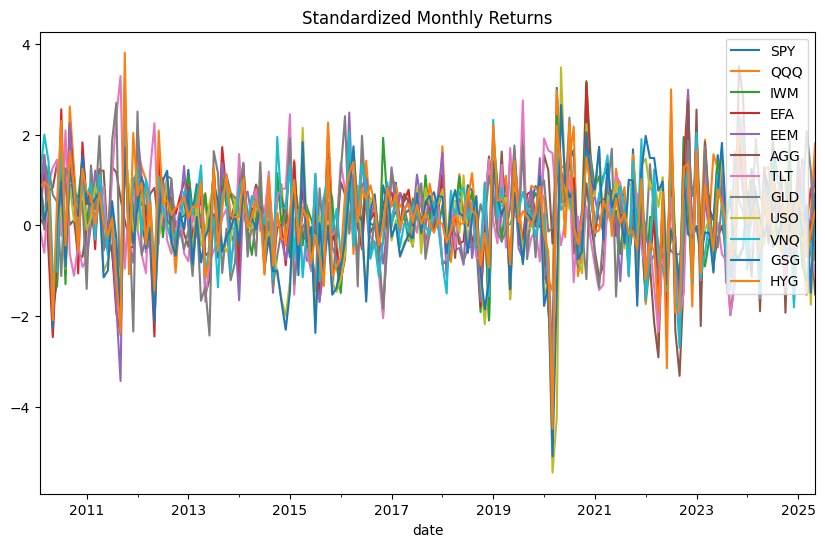

In [6]:
standardized_monthly_returns.plot(figsize= (10, 6), title = "Standardized Monthly Returns")
plt.legend(loc='upper right')
plt.show()


In [7]:
standardized_monthly_returns.head()

,SPY,QQQ,IWM,EFA,EEM,AGG,TLT,GLD,USO,VNQ,GSG,HYG
date,,,,,,,,,,,,
2010-02-28,0.744651,0.915325,0.780070,0.058765,0.340780,0.152268,-0.084553,0.720622,0.878449,1.095138,0.992441,0.837022
2010-03-31,1.453791,1.533400,1.435894,1.406601,1.557216,-0.005475,-0.605588,-0.096522,0.372811,1.997745,0.102908,0.955077
2010-04-30,0.369287,0.444818,0.989148,-0.617802,-0.033019,0.745341,0.926397,1.294645,0.254134,1.402509,0.527551,0.862404
2010-05-31,-1.896664,-1.468785,-1.313729,-2.465590,-1.802056,0.828936,1.273382,0.671631,-1.736796,-1.046385,-2.280718,-2.093010
2010-06-30,-1.235229,-1.224659,-1.351085,-0.456839,-0.268825,1.353701,1.444434,0.518096,-0.022850,-1.018626,0.012081,0.498941


# Load in Macro Data

In [8]:
FILE1             = "../data/Assignment_2_data.xlsm"

fed = pd.read_excel(FILE1, sheet_name='FF', index_col='Date')
fed.rename(columns={'Rate': 'ff'}, inplace=True)
fed = fed[~fed.index.duplicated(keep='last')]

fed = (fed            # daily EFFR
           .resample('ME').mean())   # trim to asset window

# select only >2010
fed = fed[fed.index >= '2008-01-01']
fed['rate_change_1m'] = fed['ff'].diff()

In [9]:
fed.head()

,ff,rate_change_1m
Date,,
2008-01-31,3.931429,NaN
2008-02-29,2.962500,-0.968929
2008-03-31,2.602857,-0.359643
2008-04-30,2.267727,-0.335130
2008-05-31,1.993333,-0.274394


<Axes: xlabel='Date'>

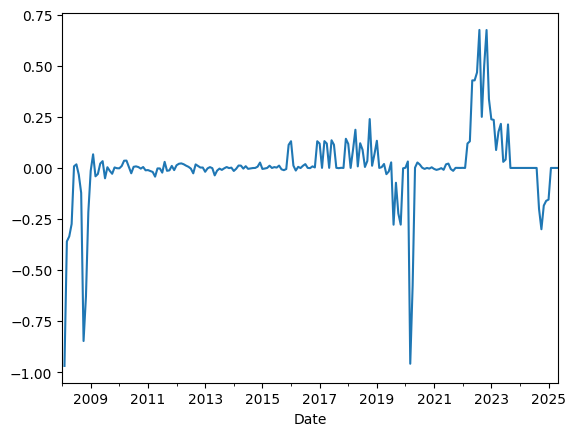

In [10]:
fed['rate_change_1m'].plot()

<Axes: xlabel='Date'>

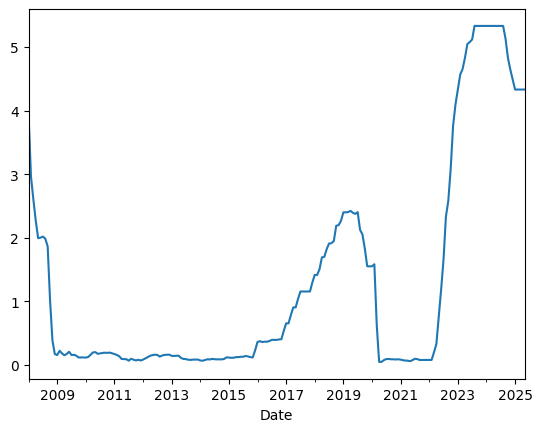

In [61]:
fed['ff'].plot()

In [11]:
ism = pd.read_excel(FILE1, sheet_name='ISM', index_col='Date')
ism = ism[~ism.index.duplicated(keep='last')]
ism = ism[ism.index >= '2010-01-01']
ism


,ISM
Date,
2010-01-31,56.3
2010-02-28,55.5
2010-03-31,58.8
2010-04-30,58.1
2010-05-31,57.4
...,...
2024-12-31,49.2
2025-01-31,50.9
2025-02-28,50.3


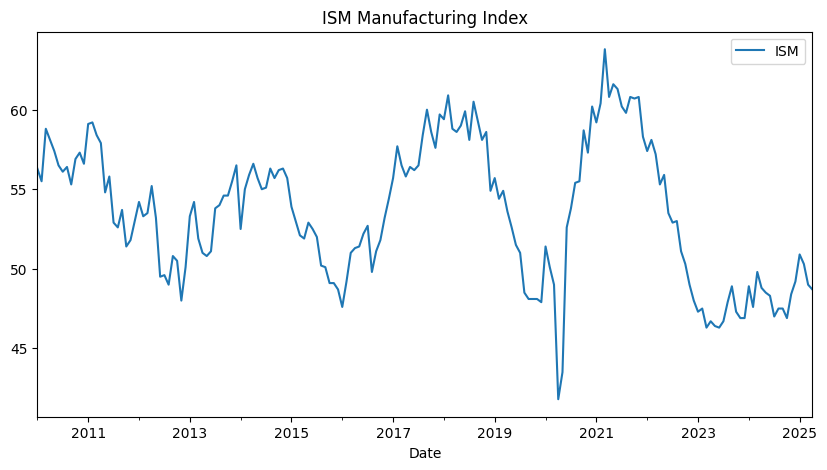

In [12]:
ism.plot(figsize = (10, 5))
plt.title("ISM Manufacturing Index")
plt.show()

In [13]:
nfp = pd.read_csv("../data/nonfarm_payrolls.csv", index_col = "observation_date")
nfp.index = pd.to_datetime(nfp.index)
nfp.rename(columns = {"PAYEMS": "nfp"}, inplace = True)
nfp.index.name = "Date"
nfp = nfp.resample('ME').mean()
nfp.head()

,nfp
Date,
2010-01-31,129802.0
2010-02-28,129705.0
2010-03-31,129865.0
2010-04-30,130120.0
2010-05-31,130643.0


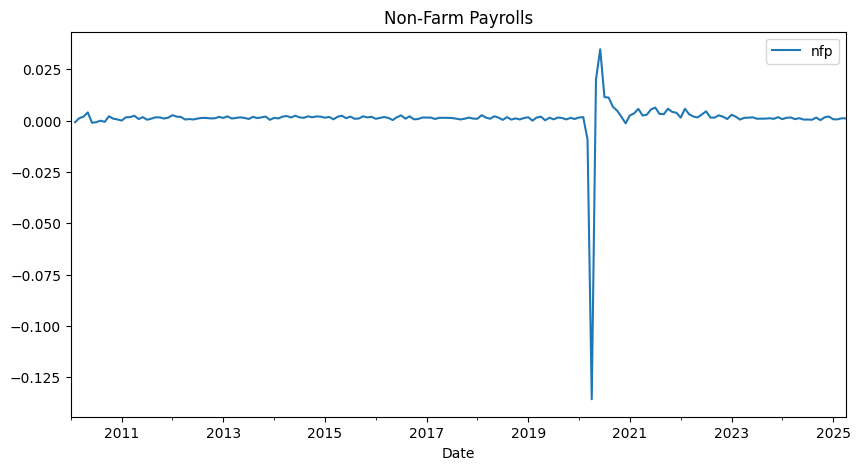

In [14]:
nfp.pct_change().plot(figsize = (10, 5))
plt.title("Non-Farm Payrolls")
plt.show()

In [15]:
pce = pd.read_csv("../data/core_pce.csv", index_col = "observation_date")
pce.index = pd.to_datetime(pce.index)
pce.rename(columns = {"PCEPILFE": "pce"}, inplace = True)
pce['pce_yoy'] = pce['pce'].pct_change(periods = 12)
pce.index.name = "Date"
pce = pce.resample("ME").mean()
pce

,pce,pce_yoy
Date,,
2008-11-30,87.952,NaN
2008-12-31,87.909,NaN
2009-01-31,87.882,NaN
2009-02-28,87.952,NaN
2009-03-31,88.015,NaN
...,...,...
2024-11-30,123.716,0.028319
2024-12-31,123.980,0.028641
2025-01-31,124.398,0.026996


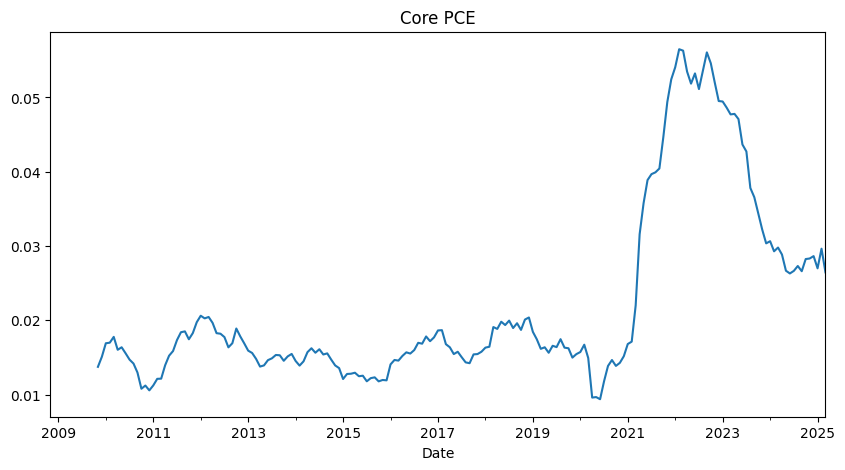

In [16]:
pce.pce_yoy.plot(figsize = (10, 5))
plt.title("Core PCE")
plt.show()

In [17]:
macro_factors = pd.concat([fed, ism, nfp, pce], axis = 1)
macro_factors
# macro_factors.columns = ['fed', 'ism', 'nfp', 'pce', 'cpi']
macro_factors


,ff,rate_change_1m,ISM,nfp,pce,pce_yoy
Date,,,,,,
2008-01-31,3.931429,NaN,NaN,NaN,NaN,NaN
2008-02-29,2.962500,-0.968929,NaN,NaN,NaN,NaN
2008-03-31,2.602857,-0.359643,NaN,NaN,NaN,NaN
2008-04-30,2.267727,-0.335130,NaN,NaN,NaN,NaN
2008-05-31,1.993333,-0.274394,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-01-31,4.330000,-0.154762,50.9,159053.0,124.398,0.026996
2025-02-28,4.330000,0.000000,50.3,159155.0,125.017,0.029641
2025-03-31,4.330000,0.000000,49.0,159340.0,125.052,0.026455


In [18]:
all_data = pd.merge(standardized_monthly_returns, macro_factors, left_index =True, right_index = True)
all_data.dropna(inplace = True)
all_data.head()

,SPY,QQQ,IWM,EFA,EEM,AGG,TLT,GLD,USO,VNQ,GSG,HYG,ff,rate_change_1m,ISM,nfp,pce,pce_yoy
2010-02-28,0.744651,0.915325,0.780070,0.058765,0.340780,0.152268,-0.084553,0.720622,0.878449,1.095138,0.992441,0.837022,0.126316,0.009474,55.5,129705.0,89.446,0.016987
2010-03-31,1.453791,1.533400,1.435894,1.406601,1.557216,-0.005475,-0.605588,-0.096522,0.372811,1.997745,0.102908,0.955077,0.161739,0.035423,58.8,129865.0,89.579,0.017770
2010-04-30,0.369287,0.444818,0.989148,-0.617802,-0.033019,0.745341,0.926397,1.294645,0.254134,1.402509,0.527551,0.862404,0.197727,0.035988,58.1,130120.0,89.625,0.016030
2010-05-31,-1.896664,-1.468785,-1.313729,-2.465590,-1.802056,0.828936,1.273382,0.671631,-1.736796,-1.046385,-2.280718,-2.093010,0.202500,0.004773,57.4,130643.0,89.724,0.016369
2010-06-30,-1.235229,-1.224659,-1.351085,-0.456839,-0.268825,1.353701,1.444434,0.518096,-0.022850,-1.018626,0.012081,0.498941,0.176364,-0.026136,56.5,130509.0,89.767,0.015556


## Build out factor model using ISM and PCE

In [64]:
oos = all_data[all_data.index >= "2025-01-01"]
in_sample = all_data[all_data.index < "2025-01-01"]

In [65]:
in_sample.columns

Index(['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'AGG', 'TLT', 'GLD', 'USO', 'VNQ',
       'GSG', 'HYG', 'ff', 'rate_change_1m', 'ISM', 'nfp', 'pce', 'pce_yoy'],
      dtype='object')

In [67]:
assets = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'AGG', 'TLT', 'GLD', 'USO', 'VNQ',
       'GSG', 'HYG']

results = pd.DataFrame()
for asset in assets:
    spy_model = OLS(in_sample[asset], add_constant(in_sample[['rate_change_1m', 'ISM', 'pce_yoy']])).fit()
    y_pred = spy_model.predict(add_constant(oos[['rate_change_1m', 'ISM', 'pce_yoy']]))
    y_actual = oos[asset]

    res = pd.DataFrame({'residual': sum(y_actual - y_pred), 
                        'rsquared': spy_model.rsquared,
                        'ff_pval': spy_model.pvalues['rate_change_1m'],
                        'ism_pval': spy_model.pvalues['ISM'],
                        'pce_pval': spy_model.pvalues['pce_yoy']}, index = [asset])
    results = pd.concat([results,  res], axis = 0)

results



,residual,rsquared,ff_pval,ism_pval,pce_pval
SPY,-1.760278,0.011429,0.459645,0.589742,0.166995
QQQ,-2.593529,0.018550,0.984566,0.375160,0.150926
IWM,-1.803052,0.032086,0.100418,0.761878,0.021097
EFA,1.760643,0.034107,0.025641,0.426734,0.050274
EEM,1.086597,0.040388,0.030316,0.473731,0.014954
AGG,1.302966,0.071843,0.487096,0.061684,0.001487
TLT,0.832881,0.034263,0.491137,0.456429,0.094395
GLD,3.258562,0.014163,0.579461,0.173697,0.876478
USO,0.961734,0.085829,0.002378,0.113040,0.998086
VNQ,0.337100,0.025900,0.171627,0.630055,0.058891


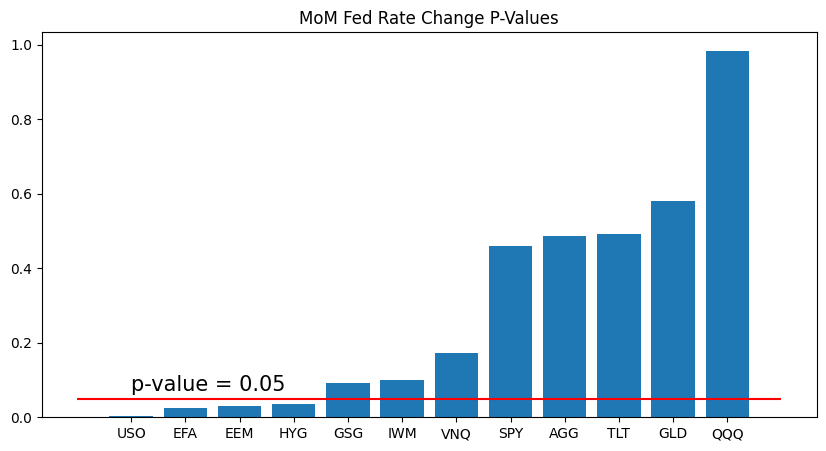

In [49]:
ff_pval = results['ff_pval'].sort_values()
plt.figure(figsize = (10, 5))
plt.bar(ff_pval.index, ff_pval.values)
plt.hlines((0.05), xmin = -1, xmax = len(results.index), color = 'red')
plt.annotate("p-value = 0.05", xy = (0, 0.05), xytext = (0, 0.07), size = 15)
plt.title("MoM Fed Rate Change P-Values")
plt.show()

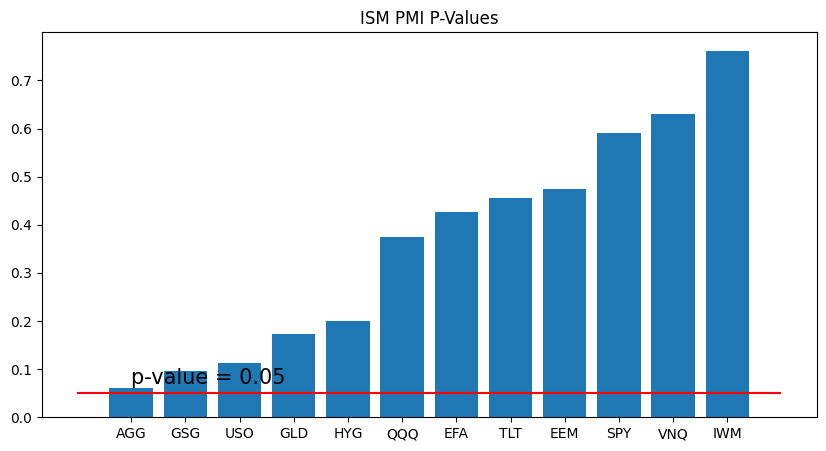

In [50]:
ism_pval = results['ism_pval'].sort_values()
plt.figure(figsize = (10, 5))
plt.bar(ism_pval.index, ism_pval.values)
plt.hlines((0.05), xmin = -1, xmax = len(results.index), color = 'red')
plt.annotate("p-value = 0.05", xy = (0, 0.05), xytext = (0, 0.07), size = 15)
plt.title("ISM PMI P-Values")
plt.show()

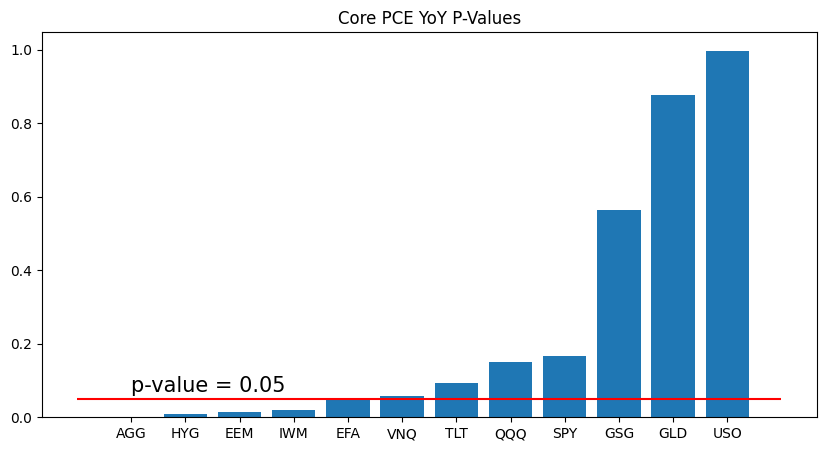

In [52]:
pce_pval = results['pce_pval'].sort_values()
plt.figure(figsize = (10, 5))
plt.bar(pce_pval.index, pce_pval.values)
plt.hlines((0.05), xmin = -1, xmax = len(results.index), color = 'red')
plt.annotate("p-value = 0.05", xy = (0, 0.05), xytext = (0, 0.07), size = 15)
plt.title("Core PCE YoY P-Values")
plt.show()

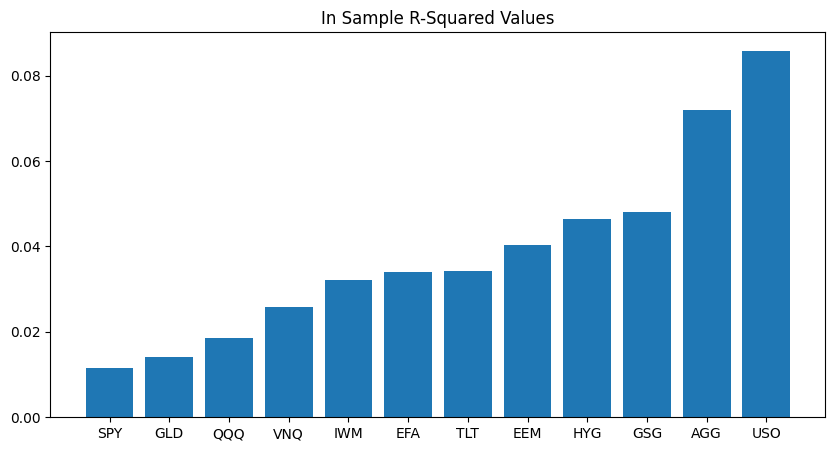

In [59]:
r2 = results['rsquared'].sort_values()
plt.figure(figsize = (10, 5))
plt.bar(r2.index, r2.values)
plt.title("In Sample R-Squared Values")
plt.show()

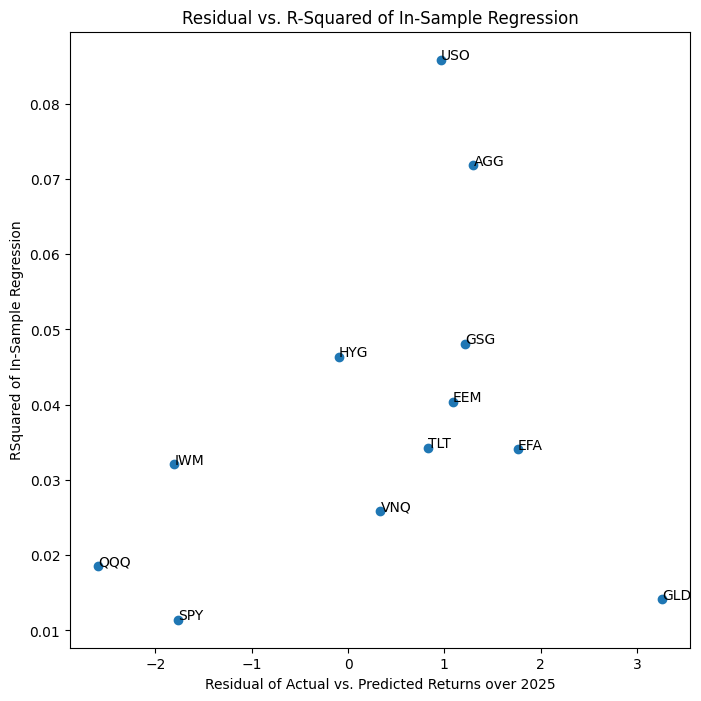

In [56]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(results['residual'], results['rsquared'])
for asset, (x, y) in results[['residual', 'rsquared']].iterrows():
    ax.annotate(asset, (x, y), fontsize = 10)
ax.set_xlabel("Residual of Actual vs. Predicted Returns over 2025")
ax.set_ylabel("RSquared of In-Sample Regression")
ax.set_title("Residual vs. R-Squared of In-Sample Regression")
plt.show()

How to decide if they are significant?
Can do either p-value or r-squared.

Run a regression for each, pull out p-values and r-squared, also use the model to forecast the next month then move to the next asset.

In [72]:
assets = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'AGG', 'TLT', 'GLD', 'USO', 'VNQ',
       'GSG', 'HYG']

rm_covid = in_sample[(in_sample.index <= "2020-01-01" )| (in_sample.index >= "2021-01-01")]
rm_covid_results = pd.DataFrame()
for asset in assets:
    spy_model = OLS(rm_covid[asset], add_constant(rm_covid[['rate_change_1m', 'ISM', 'pce_yoy']])).fit()
    y_pred = spy_model.predict(add_constant(oos[['rate_change_1m', 'ISM', 'pce_yoy']]))
    y_actual = oos[asset]

    res = pd.DataFrame({'residual': sum(y_actual - y_pred), 
                        'rsquared': spy_model.rsquared,
                        'ff_pval': spy_model.pvalues['rate_change_1m'],
                        'ism_pval': spy_model.pvalues['ISM'],
                        'pce_pval': spy_model.pvalues['pce_yoy']}, index = [asset])
    rm_covid_results = pd.concat([rm_covid_results,  res], axis = 0)

rm_covid_results

,residual,rsquared,ff_pval,ism_pval,pce_pval
SPY,-1.944781,0.007447,0.687157,0.801202,0.514974
QQQ,-2.614225,0.012766,0.594862,0.610688,0.414955
IWM,-2.059131,0.016544,0.875055,0.807560,0.139667
EFA,1.567744,0.013161,0.322005,0.443047,0.189818
EEM,0.916047,0.018881,0.336626,0.468650,0.089302
AGG,1.358951,0.061819,0.634241,0.136465,0.004868
TLT,1.013954,0.028741,0.984875,0.574704,0.067354
GLD,3.303938,0.010412,0.582495,0.276689,0.673748
USO,0.006010,0.044168,0.101685,0.090029,0.020279
VNQ,-0.012071,0.018446,0.733713,0.505945,0.276304


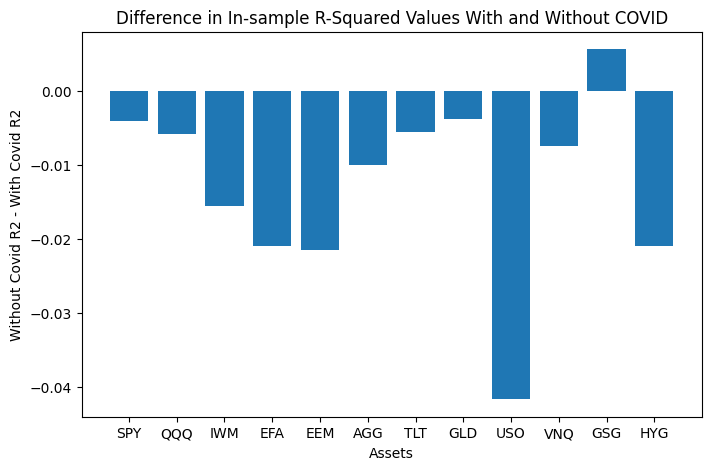

In [77]:
plt.figure(figsize = (8, 5))
plt.bar(rm_covid_results.index, rm_covid_results['rsquared'] - results['rsquared'])
plt.title("Difference in In-sample R-Squared Values With and Without COVID")
plt.xlabel("Assets")
plt.ylabel("Without Covid R2 - With Covid R2")
plt.show()